In [1]:
#Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [2]:
#Create dataframe of all details of grants
grants = pd.merge(
    left = pd.read_csv('PublicAssistanceFundedProjectsDetails.csv').drop(columns = ['hash','lastRefresh','id']), 
    right = pd.read_csv('GeoPublicAssistanceApplicants.csv').drop(columns = ['hash','lastRefresh','id']), 
    how = 'inner', 
    left_on = ['applicantId', 'disasterNumber'], 
    right_on = ['applicantId', 'disasterNumber'], 
    suffixes = ('_grant', '_applicant')
)

In [3]:
#Remove negative grant amounts
grants.drop(index = grants[grants['totalObligated'] < 0].index, inplace = True)

In [4]:
#Trim the zip code suffix
grants['zipCode'] = grants['zipCode'].str.split("-", expand = True)[0]

In [5]:
#Add USGS Flood Event Name to grants dataframe
grants = pd.merge(
    left = grants, 
    right = pd.read_csv('Floods Listing - Flood IDs.csv')[['FEMA Disaster Code', 'FEMA Event Name', 'USGS Flood Event Name']], 
    left_on ='disasterNumber', 
    right_on = 'FEMA Disaster Code'
)

In [6]:
#Aggregate grant funding by ZIP
zip_grants = grants.groupby(['zipCode', 'USGS Flood Event Name']).mean()[['totalObligated']].reset_index()

In [7]:
#Aggregate flood height by ZIP
zip_heights = pd.read_csv('FloodHeightsZIP.csv', dtype = 'object').drop(columns = ['Unnamed: 0'])

In [8]:
#Recast flood height as float
zip_heights['height_above_gnd'] = zip_heights['height_above_gnd'].astype('float')

In [9]:
#Merge two ZIP-aggregated datasets together
zip_stats = pd.merge(zip_grants, zip_heights, left_on = ['zipCode', 'USGS Flood Event Name'], right_on = ['zip', 'eventName']).drop(columns = ['zip', 'eventName'])

In [10]:
#Scatter plot of flood heigh and grant funding per zipcode
plt.figure(figsize = (9, 6))
plt.scatter(zip_stats['height_above_gnd'], zip_stats['totalObligated'] / 1e6)
plt.xlim(0,10)
plt.ylim(0, 1)
plt.title('Funds Granted vs Mean Flood Height')
plt.xlabel('Mean Flood Height, Feet')
plt.ylabel('FEMA Funds Granted per ZIP, $Millions');
plt.savefig('images/Funds Granted vs Mean Flood Height.jpg')
plt.close()

In [11]:
#Plot bargraph of correlation between mean flood height and grant allocation
corrs = zip_stats.groupby('USGS Flood Event Name').corr().loc(axis=1)['totalObligated'][:, 'height_above_gnd'].sort_values()
plt.figure(figsize = (9, 6))
plt.barh(corrs.index, corrs.values);
plt.title('Correlation of Funds Granted & Mean Flood Height')
plt.tight_layout()
plt.savefig('images/Correlation of Funds Granted & Mean Flood Height.jpg')
plt.close()

In [12]:
# Drop rows where flood height is zero because we will take the ratio between total obligated and flood height
zip_stats.drop(zip_stats[zip_stats['height_above_gnd'] == 0].index, inplace = True)
#Create column funding per foot that is ratio between funding and mean flood height
zip_stats['funding_per_foot'] = zip_stats['totalObligated'] / zip_stats['height_above_gnd']

In [13]:
#Plot boxplot of range of values for funding ratio for each storm
boxlabels = []
boxvalues =[]
for event in zip_stats['USGS Flood Event Name'].unique():
    boxlabels.append(event)
    boxvalues.append(zip_stats[zip_stats['USGS Flood Event Name'] == event]['funding_per_foot'].dropna().values)
plt.figure(figsize = (9, 6))

plt.boxplot(boxvalues, vert = False, labels = boxlabels, patch_artist = True);
plt.title('Funding Granted per Feet Average Flood Height')
plt.xlim(0, 5e5)
plt.tight_layout()
plt.savefig('images/Funding Granted per Feet Average Flood Height.jpg')
plt.close()

In [14]:
# Add USGS Flood Event Names & TimeLine Category to aggregated dataset
zip_stats = pd.merge(
    left = zip_stats,
    right = pd.read_csv('Floods Listing - Flood IDs.csv')[['USGS Flood Event Name', 'Timeline_Category']],
    on = 'USGS Flood Event Name'
)

In [15]:
#Save ZIP-Aggregated stats to CSV
zip_stats.to_csv('ZIPAggStats.csv')

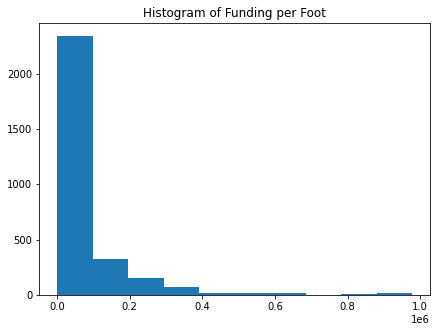

In [16]:
#Plot histogram of funding per foot to assess normality
#Funding per foot is very skewed, so the F-test is not appropriate
plt.figure(figsize = (7, 5))
plt.title('Histogram of Funding per Foot')
plt.hist(zip_stats[zip_stats['funding_per_foot'] <1e6]['funding_per_foot'])
plt.savefig('images/Histogram of Funding per Foot.jpg')

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html 

Three variations of Levene’s test are possible. The possibilities and their recommended usages are:

‘median’ : Recommended for skewed (non-normal) distributions>

‘mean’ : Recommended for symmetric, moderate-tailed distributions.

‘trimmed’ : Recommended for heavy-tailed distributions.

In [17]:
from scipy.stats import levene

In [18]:
# Difference before and after passage of PKEMRA
levene(
    zip_stats[zip_stats['Timeline_Category'] == 0]['funding_per_foot'].dropna(),
    zip_stats[zip_stats['Timeline_Category'] == 1]['funding_per_foot'].dropna(),
    center = 'median'
)

LeveneResult(statistic=1.4353423938541499, pvalue=0.2310974571159964)

In [19]:
# Difference before and after passage of SRIA
levene(
    zip_stats[zip_stats['Timeline_Category'] == 1]['funding_per_foot'].dropna(),
    zip_stats[zip_stats['Timeline_Category'] == 2]['funding_per_foot'].dropna(),
    center = 'median'
)

LeveneResult(statistic=2.6303815513305278, pvalue=0.10494578688019465)

In [20]:
# Difference before and after passage of DRRA
levene(
    zip_stats[zip_stats['Timeline_Category'] == 2]['funding_per_foot'].dropna(),
    zip_stats[zip_stats['Timeline_Category'] == 3]['funding_per_foot'].dropna(),
    center = 'median'
)

LeveneResult(statistic=0.10918733877749508, pvalue=0.7411143963906077)